# <font style="color:blue">Project 4: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://github.com/ishann/aeroscapes/blob/master/assets/data_montage.png?raw=true" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

In [ ]:
is_kaggel_run = False

In [2]:
# Cell 1: Clone repository and install dependencies
import subprocess
import os
import shutil
import sys

if is_kaggel_run:
    # Remove the correct target directory
    if os.path.exists("/kaggle/working/project"):
        shutil.rmtree("/kaggle/working/project")

    # Clone from GitHub
    subprocess.run(["git", "clone", "https://github.com/ramabyg/pjt4-semantic-segmentation.git", "/kaggle/working/project"], check=True)
    os.chdir("/kaggle/working/project")

    # Check PyTorch and CUDA versions to install correct detectron2
    import torch
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")

    print("Installing detectron2 from source...")
    # Install detectron2 from source (most reliable for Kaggle)
    subprocess.run([
        sys.executable, "-m", "pip", "install", "-q",
        "git+https://github.com/facebookresearch/detectron2.git"
    ], check=True)
    print("Installed detectron2 from source.")

    print("Installaing other dependencies...")
    # Install other requirements
    subprocess.run([
        sys.executable, "-m", "pip", "install", "-q",
        "albumentations", "pyyaml", "seaborn"
    ], check=True)

    print("✓ Repository cloned and dependencies installed!")

PyTorch version: 2.4.1+cu121
CUDA available: True
CUDA version: 12.1
Installing detectron2 from source...
Installed detectron2 from source.
Installaing other dependencies...
✓ Repository cloned and dependencies installed!


In [3]:
# Cell 2: Setup paths and imports
if is_kaggel_run:
    # Change to project directory
    os.chdir("/kaggle/working/project")
    import sys
    from pathlib import Path

    # Add src to path
    sys.path.insert(0, str(Path.cwd() / "src"))

    # Import all modules
    from src.dataset import SemanticSegmentationDataset, get_default_transforms
    from src.model import Detectron2Config
    from src.train import SemanticSegmentationTrainer
    from src.inference import SemanticSegmentationPredictor
    from src.utils import SegmentationMetrics, PathUtils
    import torch

    print(f"✓ All imports successful!")
    print(f"✓ CUDA Available: {torch.cuda.is_available()}")
    print(f"✓ Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


✓ All imports successful!
✓ CUDA Available: True
✓ Device: cuda


# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [ ]:
import sys
import os
from pathlib import Path

# Add src to path for imports
sys.path.insert(0, str(Path.cwd()))

# Standard imports
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# Project imports
from src.dataset import SemanticSegmentationDataset, get_default_transforms
from src.model import Detectron2Config, SemanticSegmentationConfig
from src.utils import SegmentationMetrics, VisualizationUtils, PathUtils
from src.train import SemanticSegmentationTrainer
from src.inference import SemanticSegmentationPredictor, create_submission_csv

# Configuration
RAND_SEED = 42
np.random.seed(RAND_SEED)
torch.manual_seed(RAND_SEED)

# Detect device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Project paths
if is_kaggel_run:
    DATA_PATH = "/kaggle/input/opencv-pytorch-segmentation-project-round2"
    OUTPUT_DIR = "/kaggle/working/outputs"
else:
    DATA_PATH = "/mnt/rama_ml/data/opencv-segmentation-project-round2/"
    OUTPUT_DIR = "./outputs"
PathUtils.ensure_dir(DATA_PATH)
PathUtils.ensure_dir(OUTPUT_DIR)

print("✓ All imports successful!")


Using device: cuda
✓ All imports successful!


In [5]:
#get image Id list from train.csv and load to dict
image_ids_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
imageIDs = image_ids_df["ImageID"].tolist()
class_names = [str(name) for name in "Background, Person, Bike, Car, Drone, Boat, Animal, Obstacle, Construction, Vegetation, Road, Sky".split(", ")]
# Load dataset
dataset = SemanticSegmentationDataset(
    data_path=DATA_PATH,
    images_folder="imgs/imgs",
    masks_folder="masks/masks",
    image_ids=imageIDs,  # Pass the list of image IDs to the dataset
    class_names=class_names
)

print(f"Total images in dataset: {len(dataset)}")
print(f"Image IDs: {dataset.image_files[:5]}...")  # Show first 5

# Split into train and validation (80:20)
train_ids, val_ids = SemanticSegmentationDataset.train_val_split(
    dataset.image_files,
    train_ratio=0.8,
    random_state=RAND_SEED
)

print(f"\nTrain set: {len(train_ids)} images")
print(f"Validation set: {len(val_ids)} images")

# Create dataset splits with transforms
train_transforms, val_transforms = get_default_transforms(image_size=512)

train_dataset = SemanticSegmentationDataset(
    data_path=DATA_PATH,
    image_ids=train_ids,
    transforms=train_transforms,
    images_folder="imgs/imgs",
    masks_folder="masks/masks",
    class_names=class_names
)

val_dataset = SemanticSegmentationDataset(
    data_path=DATA_PATH,
    image_ids=val_ids,
    transforms=val_transforms,
    images_folder="imgs/imgs",
    masks_folder="masks/masks",
    class_names=class_names
)

print(f"✓ Train dataset: {len(train_dataset)}")
print(f"✓ Val dataset: {len(val_dataset)}")


Total images in dataset: 2621
Image IDs: [6119677716839104391, 14802949761255250525, 14124813423892560492, 5482257461254211163, 10081435122427592003]...

Train set: 2096 images
Validation set: 525 images
✓ Train dataset: 2096
✓ Val dataset: 525


## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

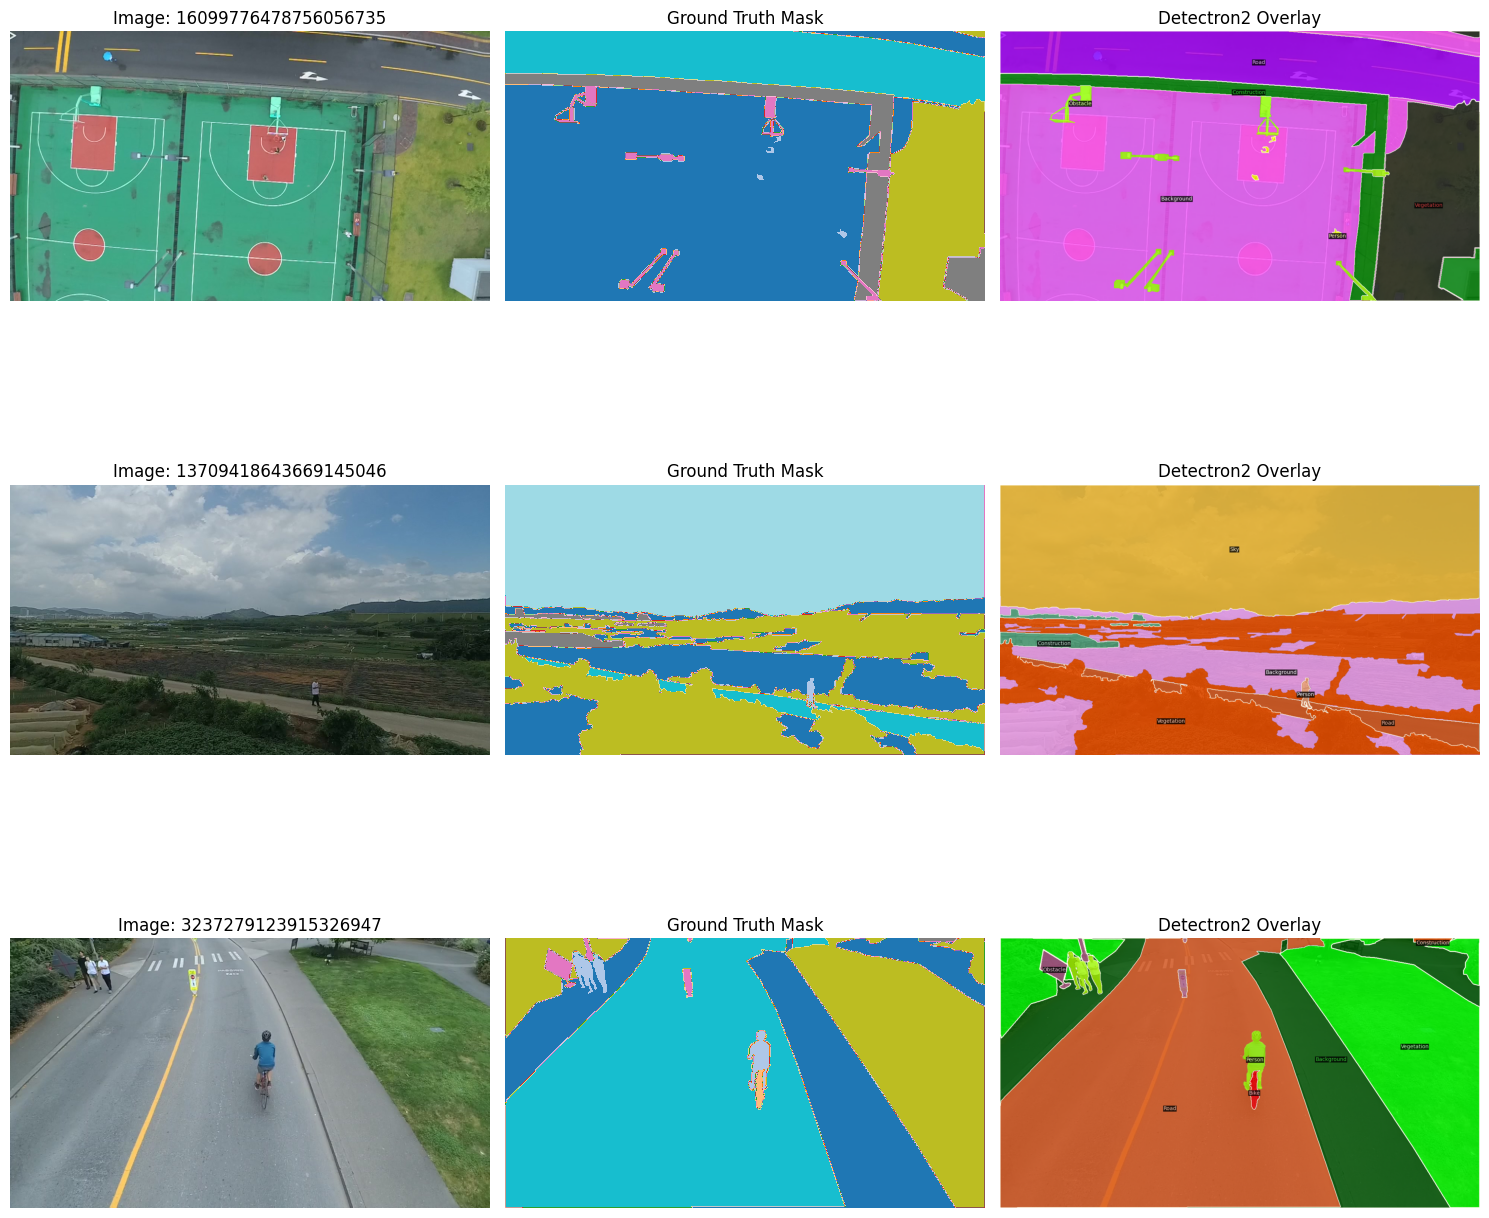

✓ Visualization complete using Detectron2 Visualizer!


In [6]:
# Visualize samples using Detectron2 Visualizer
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Create dataset for visualization (without transforms)
dataset_viz = SemanticSegmentationDataset(
    data_path=DATA_PATH,
    image_ids=train_ids[:5],  # First 5 images
    transforms=None,
    images_folder="imgs/imgs",
    masks_folder="masks/masks",
    class_names=class_names
)

# Register metadata for visualization
metadata = MetadataCatalog.get("aeroscapes_viz")
metadata.set(thing_classes=class_names, stuff_classes=class_names)

# Visualize using Detectron2 Visualizer
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for idx in range(min(3, len(dataset_viz))):
    # Get sample from dataset - returns tuple (image, mask)
    image, mask = dataset_viz[idx]

    # Convert tensors to numpy if needed
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).numpy()  # CHW -> HWC
        image = (image * 255).astype(np.uint8)
    if isinstance(mask, torch.Tensor):
        mask = mask.numpy()

    # Original image
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title(f"Image: {dataset_viz.image_files[idx]}")
    axes[idx, 0].axis('off')

    # Ground truth mask
    axes[idx, 1].imshow(mask, cmap='tab20', vmin=0, vmax=len(class_names)-1)
    axes[idx, 1].set_title("Ground Truth Mask")
    axes[idx, 1].axis('off')

    # Detectron2 overlay visualization
    v = Visualizer(image, metadata=metadata, scale=1.0)
    vis_output = v.draw_sem_seg(mask, area_threshold=0)
    axes[idx, 2].imshow(vis_output.get_image())
    axes[idx, 2].set_title("Detectron2 Overlay")
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete using Detectron2 Visualizer!")

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

In [7]:
# Create a metrics instance to use evaluation functions
metrics = SegmentationMetrics()

# Example usage with dummy predictions for testing
def test_metrics():
    """Test metrics with dummy data"""
    # Create dummy ground truth and prediction
    y_true = np.random.randint(0, 13, (512, 512))  # 13 classes
    y_pred = np.random.randint(0, 13, (512, 512))  # 13 classes

    # Calculate metrics
    iou = metrics.iou_score(y_true, y_pred, num_classes=13)
    dice = metrics.dice_score(y_true, y_pred, num_classes=13)
    pixel_acc = metrics.pixel_accuracy(y_true, y_pred)
    class_iou = metrics.class_wise_iou(y_true, y_pred, num_classes=13)

    print(f"IoU Score: {iou:.4f}")
    print(f"Dice Score: {dice:.4f}")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print(f"\nClass-wise IoU:")
    for class_id, iou_val in class_iou.items():
        print(f"  Class {class_id}: {iou_val:.4f}")

# Run test
test_metrics()

# Note: The main metrics will be calculated during training and validation


IoU Score: 0.0402
Dice Score: 0.0773
Pixel Accuracy: 0.0773

Class-wise IoU:
  Class 0: 0.0409
  Class 1: 0.0407
  Class 2: 0.0406
  Class 3: 0.0407
  Class 4: 0.0411
  Class 5: 0.0407
  Class 6: 0.0397
  Class 7: 0.0399
  Class 8: 0.0391
  Class 9: 0.0410
  Class 10: 0.0383
  Class 11: 0.0409
  Class 12: 0.0388


In [8]:
"""
MetricsCalculator class to calculate all metrics during training
"""

class MetricsCalculator:
    """Calculate and track metrics during training"""

    def __init__(self, num_classes=13):
        self.num_classes = num_classes

    def calculate_all_metrics(self, y_true, y_pred):
        """
        Calculate all metrics

        Returns:
            Dictionary with all metrics
        """
        metrics_dict = {
            'iou': SegmentationMetrics.iou_score(y_true, y_pred, self.num_classes),
            'dice': SegmentationMetrics.dice_score(y_true, y_pred, self.num_classes),
            'pixel_accuracy': SegmentationMetrics.pixel_accuracy(y_true, y_pred),
        }

        # Class-wise metrics
        class_iou = SegmentationMetrics.class_wise_iou(y_true, y_pred, self.num_classes)

        metrics_dict['class_iou'] = class_iou

        return metrics_dict

# Test the calculator
calc = MetricsCalculator(num_classes=13)
test_true = np.random.randint(0, 13, (256, 256))
test_pred = np.random.randint(0, 13, (256, 256))

all_metrics = calc.calculate_all_metrics(test_true, test_pred)
print("Metrics calculated:")
print(f"  Mean IoU: {all_metrics['iou']:.4f}")
print(f"  Mean Dice: {all_metrics['dice']:.4f}")
print(f"  Pixel Accuracy: {all_metrics['pixel_accuracy']:.4f}")
print("✓ MetricsCalculator ready!")

Metrics calculated:
  Mean IoU: 0.0408
  Mean Dice: 0.0783
  Pixel Accuracy: 0.0783
✓ MetricsCalculator ready!


# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [ ]:
# Initialize Detectron2 Config for semantic segmentation
config = Detectron2Config(
    model_name="mask_rcnn_R_50_FPN_3x",  # Using Mask R-CNN with FPN
    num_classes=13,  # 12 classes + background
    num_gpus=1,  # Adjust based on your hardware
    batch_size_per_image=512,  # ROI batch size
    learning_rate=0.02,  # Base learning rate
    max_iter=1000,  # Total training iterations
    checkpoint_period=500,  # Save checkpoint every 500 iterations
    ims_per_batch=4,  # Images per batch (solver parameter)
    lr_steps=(500, 800),  # LR scheduler milestones (reduce at 50% and 75%)
    freeze_at=0,  # Don't freeze backbone (0-5, higher=more frozen)
    input_min_size_train=(512,),  # Min image size during training
    input_max_size_train=512,  # Max image size during training
    input_min_size_test=512,  # Min image size during testing
    input_max_size_test=512,  # Max image size during testing
)

# Get the config object
cfg = config.get_cfg()
config.set_output_dir(OUTPUT_DIR)

print("="*70)
print("COMPLETE MODEL & TRAINING CONFIGURATION")
print("="*70)
print("\nModel:")
print(f"  Architecture: {cfg.MODEL.BACKBONE.NAME}")
print(f"  Classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
print(f"  Backbone Freeze Level: {cfg.MODEL.BACKBONE.FREEZE_AT}")

print("\nSolver (Training):")
print(f"  Learning Rate: {cfg.SOLVER.BASE_LR}")
print(f"  Max Iterations: {cfg.SOLVER.MAX_ITER}")
print(f"  Batch Size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"  LR Milestones: {cfg.SOLVER.STEPS}")
print(f"  Checkpoint Period: {cfg.SOLVER.CHECKPOINT_PERIOD}")

print("\nInput:")
print(f"  Train Image Size: {cfg.INPUT.MIN_SIZE_TRAIN} - {cfg.INPUT.MAX_SIZE_TRAIN}")
print(f"  Test Image Size: {cfg.INPUT.MIN_SIZE_TEST} - {cfg.INPUT.MAX_SIZE_TEST}")

print(f"\nOutput Directory: {cfg.OUTPUT_DIR}")
print("="*70)
print("✓ Configuration complete! Ready for training.")

COMPLETE MODEL & TRAINING CONFIGURATION

Model:
  Architecture: build_resnet_fpn_backbone
  Classes: 13
  Backbone Freeze Level: 0

Solver (Training):
  Learning Rate: 0.02
  Max Iterations: 1000
  Batch Size: 4
  LR Milestones: (500, 800)
  Checkpoint Period: 500

Input:
  Train Image Size: (512,) - 512
  Test Image Size: 512 - 512

Output Directory: ./output
✓ Configuration complete! Ready for training.


In [10]:
# Build the model from config
from detectron2.modeling import build_model

model = build_model(cfg)
model.to(DEVICE)

print("Model Architecture Summary:")
print(f"  Total Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"  Device: {DEVICE}")

# Show model structure
print("\nModel Backbone:")
print(model.backbone)

print("\n✓ Model built and ready!")


Model Architecture Summary:
  Total Parameters: 43,982,622
  Trainable Parameters: 43,982,622
  Device: cuda

Model Backbone:
FPN(
  (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
  (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (top_block): LastLevelMaxPool()
  (bottom_up): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
     

In [11]:
# Setup optimizer and learning rate scheduler
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR

# Optimizer
optimizer = SGD(
    model.parameters(),
    lr=0.02,
    momentum=0.9,
    weight_decay=0.0001,
)

# Learning rate scheduler
max_iter = 10000
steps = [max_iter // 2, max_iter * 3 // 4]  # Reduce LR at 50% and 75% of training
scheduler = MultiStepLR(
    optimizer,
    milestones=steps,
    gamma=0.1,  # Reduce LR by factor of 10
)

print("Optimizer Configuration:")
print(f"  Type: SGD")
print(f"  Learning Rate: {optimizer.param_groups[0]['lr']}")
print(f"  Momentum: {optimizer.param_groups[0]['momentum']}")
print(f"  Weight Decay: {optimizer.param_groups[0]['weight_decay']}")

print("\nLR Scheduler Configuration:")
print(f"  Type: MultiStepLR")
print(f"  Milestones: {steps}")
print(f"  Gamma: 0.1")

print("\n✓ Optimizer and scheduler configured!")


Optimizer Configuration:
  Type: SGD
  Learning Rate: 0.02
  Momentum: 0.9
  Weight Decay: 0.0001

LR Scheduler Configuration:
  Type: MultiStepLR
  Milestones: [5000, 7500]
  Gamma: 0.1

✓ Optimizer and scheduler configured!


# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


In [12]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import time

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Adjust based on GPU memory
    shuffle=True,
    num_workers=0,  # Change to 2-4 if on Linux/Mac
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
)

print(f"Train loader: {len(train_loader)} batches")
print(f"Val loader: {len(val_loader)} batches")

# Note: For actual training with Detectron2, we use the trainer class
# which handles all the complexity. The following is a template for reference.

print("\n" + "="*60)
print("TRAINING SETUP COMPLETE")
print("="*60)
print("\nTo start training, use one of these options:\n")
print("Option 1: Using SemanticSegmentationTrainer (Full Detectron2)")
print("  trainer = SemanticSegmentationTrainer(")
print("      config, DATA_PATH, train_ids, val_ids, OUTPUT_DIR")
print("  )")
print("  trainer.train()")
print("\nOption 2: Local debugging with DataLoaders")
print("  - Iterate through train_loader and val_loader")
print("  - Use model and optimizer for custom training loop")
print("\n✓ Ready for training!")


Train loader: 524 batches
Val loader: 132 batches

TRAINING SETUP COMPLETE

To start training, use one of these options:

Option 1: Using SemanticSegmentationTrainer (Full Detectron2)
  trainer = SemanticSegmentationTrainer(
      config, DATA_PATH, train_ids, val_ids, OUTPUT_DIR
  )
  trainer.train()

Option 2: Local debugging with DataLoaders
  - Iterate through train_loader and val_loader
  - Use model and optimizer for custom training loop

✓ Ready for training!


In [13]:
# DETECTRON2 DATASET REGISTRATION (using cfg from Cell 17)
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog

def get_dataset_dicts(image_ids, data_path, images_folder, masks_folder, class_names):
    """Convert dataset to Detectron2 format"""
    dataset_dicts = []
    for img_id in image_ids:
        record = {}
        img_path = Path(data_path) / images_folder / f"{img_id}.jpg"
        mask_path = Path(data_path) / masks_folder / f"{img_id}.png"

        if img_path.exists() and mask_path.exists():
            record["file_name"] = str(img_path)
            record["image_id"] = img_id
            record["height"] = 512
            record["width"] = 512
            dataset_dicts.append(record)

    return dataset_dicts

# Register datasets with Detectron2
try:
    DatasetCatalog.register("aeroscapes_train",
                           lambda: get_dataset_dicts(train_ids, DATA_PATH, "imgs/imgs", "masks/masks", class_names))
    DatasetCatalog.register("aeroscapes_val",
                           lambda: get_dataset_dicts(val_ids, DATA_PATH, "imgs/imgs", "masks/masks", class_names))

    # Register metadata with class names
    MetadataCatalog.get("aeroscapes_train").set(thing_classes=class_names)
    MetadataCatalog.get("aeroscapes_val").set(thing_classes=class_names)

    print("✓ Datasets registered with Detectron2")
except Exception as e:
    print(f"⚠ Datasets already registered or error: {e}")

# Configure dataset references in cfg (reusing cfg from Cell 17)
cfg.DATASETS.TRAIN = ("aeroscapes_train",)
cfg.DATASETS.TEST = ("aeroscapes_val",)

print("\n" + "="*70)
print("DATASET REGISTRATION COMPLETE")
print("="*70)
print(f"Train Dataset: {cfg.DATASETS.TRAIN}")
print(f"Val Dataset: {cfg.DATASETS.TEST}")
print(f"\nUsing pre-configured 'cfg' from Cell 17:")
print(f"  Max Iterations: {cfg.SOLVER.MAX_ITER}")
print(f"  Batch Size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"  Learning Rate: {cfg.SOLVER.BASE_LR}")
print(f"  Output Dir: {cfg.OUTPUT_DIR}")
print("="*70)

✓ Datasets registered with Detectron2

DATASET REGISTRATION COMPLETE
Train Dataset: ('aeroscapes_train',)
Val Dataset: ('aeroscapes_val',)

Using pre-configured 'cfg' from Cell 17:
  Max Iterations: 1000
  Batch Size: 4
  Learning Rate: 0.02
  Output Dir: ./output


In [14]:
# Run Detectron2 Training with DefaultTrainer using cell 8 datasets
from torch.utils.data import DataLoader, BatchSampler
from detectron2.data.samplers import TrainingSampler

class CustomTrainer(DefaultTrainer):
    """
    Custom trainer that uses pre-processed datasets from cell 8
    with consistent 512x512 transforms instead of Detectron2's default pipeline
    """

    @classmethod
    def build_train_loader(cls, cfg):
        """
        Override: Use pre-processed train_dataset from cell 8
        Returns: PyTorch DataLoader with proper batching
        """
        from detectron2.structures import Instances, Boxes, BitMasks

        def collate_fn_batches(batch):
            """Convert batch of dataset items to Detectron2-compatible format"""
            # batch = [(image_tensor, mask_tensor), ...]
            # image_tensor: [C, H, W] (normalized 0-1 or 0-255)
            # mask_tensor: [H, W] (class indices)

            batch_data = []
            for image, mask in batch:
                # Convert tensor to numpy if needed
                if isinstance(image, torch.Tensor):
                    image = image.cpu().numpy()
                if isinstance(mask, torch.Tensor):
                    mask = mask.cpu().numpy()

                # Convert [C, H, W] image to [H, W, C] for Detectron2
                if image.ndim == 3 and image.shape[0] in [1, 3]:
                    image = np.transpose(image, (1, 2, 0))

                # Ensure uint8 format (0-255)
                if image.max() <= 1.0:
                    image = (image * 255).astype(np.uint8)
                else:
                    image = image.astype(np.uint8)

                # Convert semantic segmentation to instance annotations
                h, w = mask.shape
                instances = Instances((h, w))

                sem_seg = torch.from_numpy(mask.astype(np.int32))
                unique_classes = torch.unique(sem_seg)
                unique_classes = unique_classes[unique_classes > 0]  # Skip background (class 0)

                class_masks = []
                class_labels = []
                boxes_list = []

                if len(unique_classes) > 0:
                    for class_id in unique_classes:
                        class_mask = (sem_seg == class_id).numpy().astype(np.uint8)

                        # Find bounding box for this class
                        rows = np.any(class_mask, axis=1)
                        cols = np.any(class_mask, axis=0)

                        if rows.any() and cols.any():
                            y_min, y_max = np.where(rows)[0][[0, -1]]
                            x_min, x_max = np.where(cols)[0][[0, -1]]

                            # Ensure boxes are valid (xmax > xmin, ymax > ymin)
                            if x_max > x_min and y_max > y_min:
                                class_masks.append(torch.from_numpy(class_mask.astype(np.float32)))
                                class_labels.append(int(class_id))
                                boxes_list.append([float(x_min), float(y_min), float(x_max + 1), float(y_max + 1)])

                # Set instances (even if empty)
                if class_masks:
                    # ✅ FIXED: Wrap masks in BitMasks structure
                    instances.gt_masks = BitMasks(torch.stack(class_masks))
                    instances.gt_classes = torch.tensor(class_labels, dtype=torch.int64)
                    instances.gt_boxes = Boxes(torch.tensor(boxes_list, dtype=torch.float32))
                else:
                    # Empty image - must still create valid empty instances
                    instances.gt_masks = BitMasks(torch.zeros((0, h, w), dtype=torch.float32))
                    instances.gt_classes = torch.zeros(0, dtype=torch.int64)
                    instances.gt_boxes = Boxes(torch.zeros((0, 4), dtype=torch.float32))

                batch_data.append({
                    "image": torch.from_numpy(image).permute(2, 0, 1).float() / 255.0,
                    "instances": instances
                })

            return batch_data

        sampler = TrainingSampler(len(train_dataset))
        batch_sampler = BatchSampler(
            sampler,
            batch_size=cfg.SOLVER.IMS_PER_BATCH,
            drop_last=True
        )

        return DataLoader(
            train_dataset,  # Use pre-processed dataset from cell 8
            num_workers=0,
            batch_sampler=batch_sampler,
            collate_fn=collate_fn_batches,
        )

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        """
        Override: Use pre-processed val_dataset from cell 8
        """
        from detectron2.structures import Instances, Boxes, BitMasks

        def collate_fn_batches(batch):
            batch_data = []
            for image, mask in batch:
                if isinstance(image, torch.Tensor):
                    image = image.cpu().numpy()
                if isinstance(mask, torch.Tensor):
                    mask = mask.cpu().numpy()

                if image.ndim == 3 and image.shape[0] in [1, 3]:
                    image = np.transpose(image, (1, 2, 0))

                if image.max() <= 1.0:
                    image = (image * 255).astype(np.uint8)
                else:
                    image = image.astype(np.uint8)

                # Convert semantic segmentation to instances (same as train_loader)
                h, w = mask.shape
                instances = Instances((h, w))

                sem_seg = torch.from_numpy(mask.astype(np.int32))
                unique_classes = torch.unique(sem_seg)
                unique_classes = unique_classes[unique_classes > 0]  # Skip background

                class_masks = []
                class_labels = []
                boxes_list = []

                if len(unique_classes) > 0:
                    for class_id in unique_classes:
                        class_mask = (sem_seg == class_id).numpy().astype(np.uint8)
                        rows = np.any(class_mask, axis=1)
                        cols = np.any(class_mask, axis=0)

                        if rows.any() and cols.any():
                            y_min, y_max = np.where(rows)[0][[0, -1]]
                            x_min, x_max = np.where(cols)[0][[0, -1]]

                            if x_max > x_min and y_max > y_min:
                                class_masks.append(torch.from_numpy(class_mask.astype(np.float32)))
                                class_labels.append(int(class_id))
                                boxes_list.append([float(x_min), float(y_min), float(x_max + 1), float(y_max + 1)])

                if class_masks:
                    # ✅ FIXED: Wrap masks in BitMasks structure
                    instances.gt_masks = BitMasks(torch.stack(class_masks))
                    instances.gt_classes = torch.tensor(class_labels, dtype=torch.int64)
                    instances.gt_boxes = Boxes(torch.tensor(boxes_list, dtype=torch.float32))
                else:
                    instances.gt_masks = BitMasks(torch.zeros((0, h, w), dtype=torch.float32))
                    instances.gt_classes = torch.zeros(0, dtype=torch.int64)
                    instances.gt_boxes = Boxes(torch.zeros((0, 4), dtype=torch.float32))

                batch_data.append({
                    "image": torch.from_numpy(image).permute(2, 0, 1).float() / 255.0,
                    "instances": instances
                })

            return batch_data

        return DataLoader(
            val_dataset,  # Use pre-processed dataset from cell 8
            batch_size=cfg.SOLVER.IMS_PER_BATCH,
            shuffle=False,
            num_workers=0,
            collate_fn=collate_fn_batches,
            drop_last=False
        )

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """Build evaluator for validation"""
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return None

print("✓ CustomTrainer class defined and ready!")

✓ CustomTrainer class defined and ready!


In [ ]:
# Initialize and run trainer with progress monitoring
import logging
import sys
import time
from datetime import timedelta
from detectron2.engine import hooks

# Setup logging to see training progress
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    stream=sys.stdout
)

# Reduce verbosity from detectron2
logging.getLogger('detectron2').setLevel(logging.WARNING)

print("Starting Detectron2 training...")
print("="*70)
print("\nUsing pre-processed datasets from cell 8:")
print(f"   Train: {len(train_dataset)} images (512x512 with transforms)")
print(f"   Val: {len(val_dataset)} images (512x512 with transforms)")
print(f"\nTraining Configuration:")
print(f"   Batch Size: {cfg.SOLVER.IMS_PER_BATCH}")
print(f"   Max Iterations: {cfg.SOLVER.MAX_ITER}")
print(f"   Learning Rate: {cfg.SOLVER.BASE_LR}")
print(f"   Image Size: 512x512")
print("="*70 + "\n")

# Custom hook to print iteration messages
class IterationPrintingHook(hooks.HookBase):
    def __init__(self, freq=10):
        self.freq = freq
        self.train_start_time = None

    def before_train(self):
        self.train_start_time = time.time()

    def after_step(self):
        itr = self.trainer.iter
        if (itr + 1) % self.freq == 0:
            storage = self.trainer.storage

            # Get loss from storage
            latest = storage.latest()
            loss_dict = {k: v for k, v in latest.items() if 'loss' in k}

            if loss_dict:
                # Fix: handle tuple values in loss_dict
                loss_str = ", ".join([
                    f"{k}: {v[0]:.4f}" if isinstance(v, tuple) else f"{k}: {v:.4f}"
                    for k, v in loss_dict.items()
                ])
            else:
                loss_str = "N/A"

            # Calculate speed
            if self.train_start_time is not None:
                elapsed_time = time.time() - self.train_start_time
                speed = (itr + 1) / elapsed_time if elapsed_time > 0 else 0
                eta_seconds = (cfg.SOLVER.MAX_ITER - itr - 1) / speed if speed > 0 else 0
                eta = str(timedelta(seconds=int(eta_seconds)))
            else:
                speed = 0
                eta = "N/A"

            max_itr = cfg.SOLVER.MAX_ITER
            print(f"[Iteration {itr+1:5d}/{max_itr}] {loss_str} | Speed: {speed:.2f} iter/s | ETA: {eta}")


def run_validation_metrics(predictor, val_ids, data_path, max_samples=None):
    from pathlib import Path
    import numpy as np
    import cv2

    metrics = SegmentationMetrics()
    iou_scores = []
    dice_scores = []

    sample_ids = val_ids if max_samples is None else val_ids[:max_samples]
    for img_id in sample_ids:
        img_path = Path(data_path) / "imgs/imgs" / f"{img_id}.jpg"
        mask_path = Path(data_path) / "masks/masks" / f"{img_id}.png"
        if not img_path.exists() or not mask_path.exists():
            continue

        image = cv2.imread(str(img_path))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        pred_mask, _ = predictor.predict(image_rgb)
        iou = metrics.iou_score(gt_mask, pred_mask, num_classes=13)
        dice = metrics.dice_score(gt_mask, pred_mask, num_classes=13)
        iou_scores.append(iou)
        dice_scores.append(dice)

    if not iou_scores:
        return None

    return {
        "count": len(iou_scores),
        "mean_iou": float(np.mean(iou_scores)),
        "mean_dice": float(np.mean(dice_scores)),
    }


try:
    trainer = CustomTrainer(cfg)

    # Register the custom hook
    trainer.register_hooks([IterationPrintingHook(freq=10)])

    trainer.resume_or_load(resume=False)

    # Train with progress monitoring
    print("Training started...\n")
    print("-" * 80 + "\n")

    training_start = time.time()
    trainer.train()
    training_elapsed = time.time() - training_start

    # Run validation metrics on the val split
    from src.inference import SemanticSegmentationPredictor

    model_path = f"{cfg.OUTPUT_DIR}/model_final.pth"
    if Path(model_path).exists():
        print("\nRunning validation metrics on val_dataset...")
        predictor = SemanticSegmentationPredictor(
            cfg_or_model_path=cfg,
            model_weights=model_path,
            device=str(DEVICE),
        )
        validation_result = run_validation_metrics(
            predictor,
            val_ids,
            DATA_PATH,
            max_samples=50,
        )
        if validation_result is None:
            print("Validation skipped: no valid samples found.")
        else:
            print(
                "Validation summary (subset): "
                f"samples={validation_result['count']}, "
                f"mean IoU={validation_result['mean_iou']:.4f}, "
                f"mean Dice={validation_result['mean_dice']:.4f}"
            )
    else:
        print(f"Validation skipped: model not found at {model_path}")

    print("\n" + "-" * 80)
    print("\n" + "="*70)
    print("TRAINING COMPLETED SUCCESSFULLY!")
    print(f"   Total time: {str(timedelta(seconds=int(training_elapsed)))}")
    print(f"   Model saved to: {cfg.OUTPUT_DIR}/model_final.pth")
    print(f"   Checkpoints saved to: {cfg.OUTPUT_DIR}")
    print("="*70)

except KeyboardInterrupt:
    print("\n\nTraining interrupted by user!")
    print(f"   Checkpoint saved to: {cfg.OUTPUT_DIR}")

except Exception as e:
    print(f"\nTraining error: {e}")
    import traceback
    traceback.print_exc()
    print("\nTroubleshooting:")
    print("  1. GPU memory: Run 'nvidia-smi' in terminal")
    print("  2. Reduce batch size if out of memory")
    print("  3. Verify dataset paths are correct")
    print("  4. Check train_dataset and val_dataset are properly created")

Starting Detectron2 training...

📊 Using pre-processed datasets from cell 8:
   Train: 2096 images (512x512 with transforms)
   Val: 525 images (512x512 with transforms)

🔧 Training Configuration:
   Batch Size: 4
   Max Iterations: 1000
   Learning Rate: 0.02
   Image Size: 512x512

[02/17 00:54:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

model_final_f10217.pkl: 178MB [00:00, 201MB/s]                             


🚀 Training started...

--------------------------------------------------------------------------------

[02/17 00:54:08 d2.engine.train_loop]: Starting training from iteration 0
[Iteration    10/1000] total_loss: 4.1055, loss_cls: 2.3408, loss_box_reg: 0.3583, loss_mask: 0.6935, loss_rpn_cls: 0.6540, loss_rpn_loc: 0.0589 | Speed: 0.84 iter/s | ETA: 0:19:43
[02/17 00:54:27 d2.utils.events]:  eta: 0:12:24  iter: 19  total_loss: 4.541  loss_cls: 2.303  loss_box_reg: 0.2458  loss_mask: 0.6931  loss_rpn_cls: 1.129  loss_rpn_loc: 0.1168    time: 0.7559  last_time: 0.8430  data_time: 0.3026  last_data_time: 0.3680   lr: 2.342e-05  max_mem: 2894M
[Iteration    20/1000] total_loss: 3.7974, loss_cls: 1.5366, loss_box_reg: 0.2806, loss_mask: 0.6902, loss_rpn_cls: 1.1053, loss_rpn_loc: 0.1846 | Speed: 0.61 iter/s | ETA: 0:26:54
[Iteration    30/1000] total_loss: 3.2465, loss_cls: 0.7606, loss_box_reg: 0.2245, loss_mask: 0.6874, loss_rpn_cls: 1.2766, loss_rpn_loc: 0.2974 | Speed: 0.74 iter/s | ETA

In [19]:
# Load Trained Model for Inference
from detectron2.engine import DefaultPredictor

def load_trained_model(model_path, cfg, device='cuda'):
    """Load trained Detectron2 model for inference"""

    if not Path(model_path).exists():
        print(f"❌ Model not found at: {model_path}")
        print("   Train the model first using DefaultTrainer (see cell above)")
        return None

    try:
        cfg.MODEL.WEIGHTS = model_path
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence threshold

        predictor = DefaultPredictor(cfg)
        print(f"✓ Model loaded from: {model_path}")
        return predictor

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None

# Load model after training completes
model_path = f"{OUTPUT_DIR}/model_final.pth"
predictor = load_trained_model(model_path, cfg, DEVICE)

if predictor:
    print("\n📊 Model Statistics:")
    print(f"   Backbone: {cfg.MODEL.BACKBONE.NAME}")
    print(f"   Classes: {cfg.MODEL.ROI_HEADS.NUM_CLASSES}")
    print(f"   Score Threshold: {cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST}")
    print("\n✓ Model ready for inference!")

[02/17 01:12:38 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/outputs/model_final.pth ...
✓ Model loaded from: /kaggle/working/outputs/model_final.pth

📊 Model Statistics:
   Backbone: build_resnet_fpn_backbone
   Classes: 13
   Score Threshold: 0.5

✓ Model ready for inference!


## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



In [20]:
# Load a trained model for inference
# Point to your trained model weights
model_weights_path = "/kaggle/working/outputs/model_final.pth"  # After training

try:
    predictor = SemanticSegmentationPredictor(
        cfg_or_model_path=cfg,  # Use the config we created earlier
        model_weights=model_weights_path,
        device=str(DEVICE),
    )
    print("✓ Model loaded successfully!")
except FileNotFoundError:
    print("⚠ Model weights not found. Train the model first.")
    print("  Expected path:", model_weights_path)
    predictor = None

# Example inference on a single image
if predictor is not None and len(val_ids) > 0:
    # Load a test image
    test_image_id = val_ids[0]
    test_image_path = Path(DATA_PATH) / "images" / f"{test_image_id}.jpg"
    test_mask_path = Path(DATA_PATH) / "masks" / f"{test_image_id}.png"

    if test_image_path.exists():
        # Load image
        test_image = cv2.imread(str(test_image_path))
        test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

        # Load ground truth
        test_mask = cv2.imread(str(test_mask_path), cv2.IMREAD_GRAYSCALE)

        # Make prediction
        pred_mask, metadata = predictor.predict(test_image_rgb)

        # Visualize
        viz.plot_predictions(test_image_rgb, test_mask, pred_mask,
                            title=f"Inference Result - {test_image_id}")
        plt.show()

        # Calculate metrics
        iou = SegmentationMetrics.iou_score(test_mask, pred_mask, num_classes=13)
        dice = SegmentationMetrics.dice_score(test_mask, pred_mask, num_classes=13)

        print(f"Image: {test_image_id}")
        print(f"  IoU:  {iou:.4f}")
        print(f"  Dice: {dice:.4f}")
else:
    print("Sample inference will be available after training.")


[02/17 01:12:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/outputs/model_final.pth ...
✓ Model loaded successfully!


Performing batch inference on validation samples...

--- Sample 1: img_id=14068958142720419651 ---
  img_path exists: True -> /kaggle/input/opencv-pytorch-segmentation-project-round2/imgs/imgs/14068958142720419651.jpg
  mask_path exists: True -> /kaggle/input/opencv-pytorch-segmentation-project-round2/masks/masks/14068958142720419651.png
  image_rgb shape: (720, 1280, 3), dtype: uint8, min: 0, max: 255
  gt_mask shape: (720, 1280), dtype: uint8, unique values: [ 0  1  9 10]
  pred_mask shape: (720, 1280), dtype: int32, unique values: [0]
  pred_mask min: 0, max: 0
  ⚠️ WARNING: pred_mask is ALL ZEROS - model may not be predicting correctly!
  raw_output type: <class 'dict'>
  IoU: 0.7260, Dice: 0.7392

--- Sample 2: img_id=9715584069494886965 ---
  img_path exists: True -> /kaggle/input/opencv-pytorch-segmentation-project-round2/imgs/imgs/9715584069494886965.jpg
  mask_path exists: True -> /kaggle/input/opencv-pytorch-segmentation-project-round2/masks/masks/9715584069494886965.png
  im

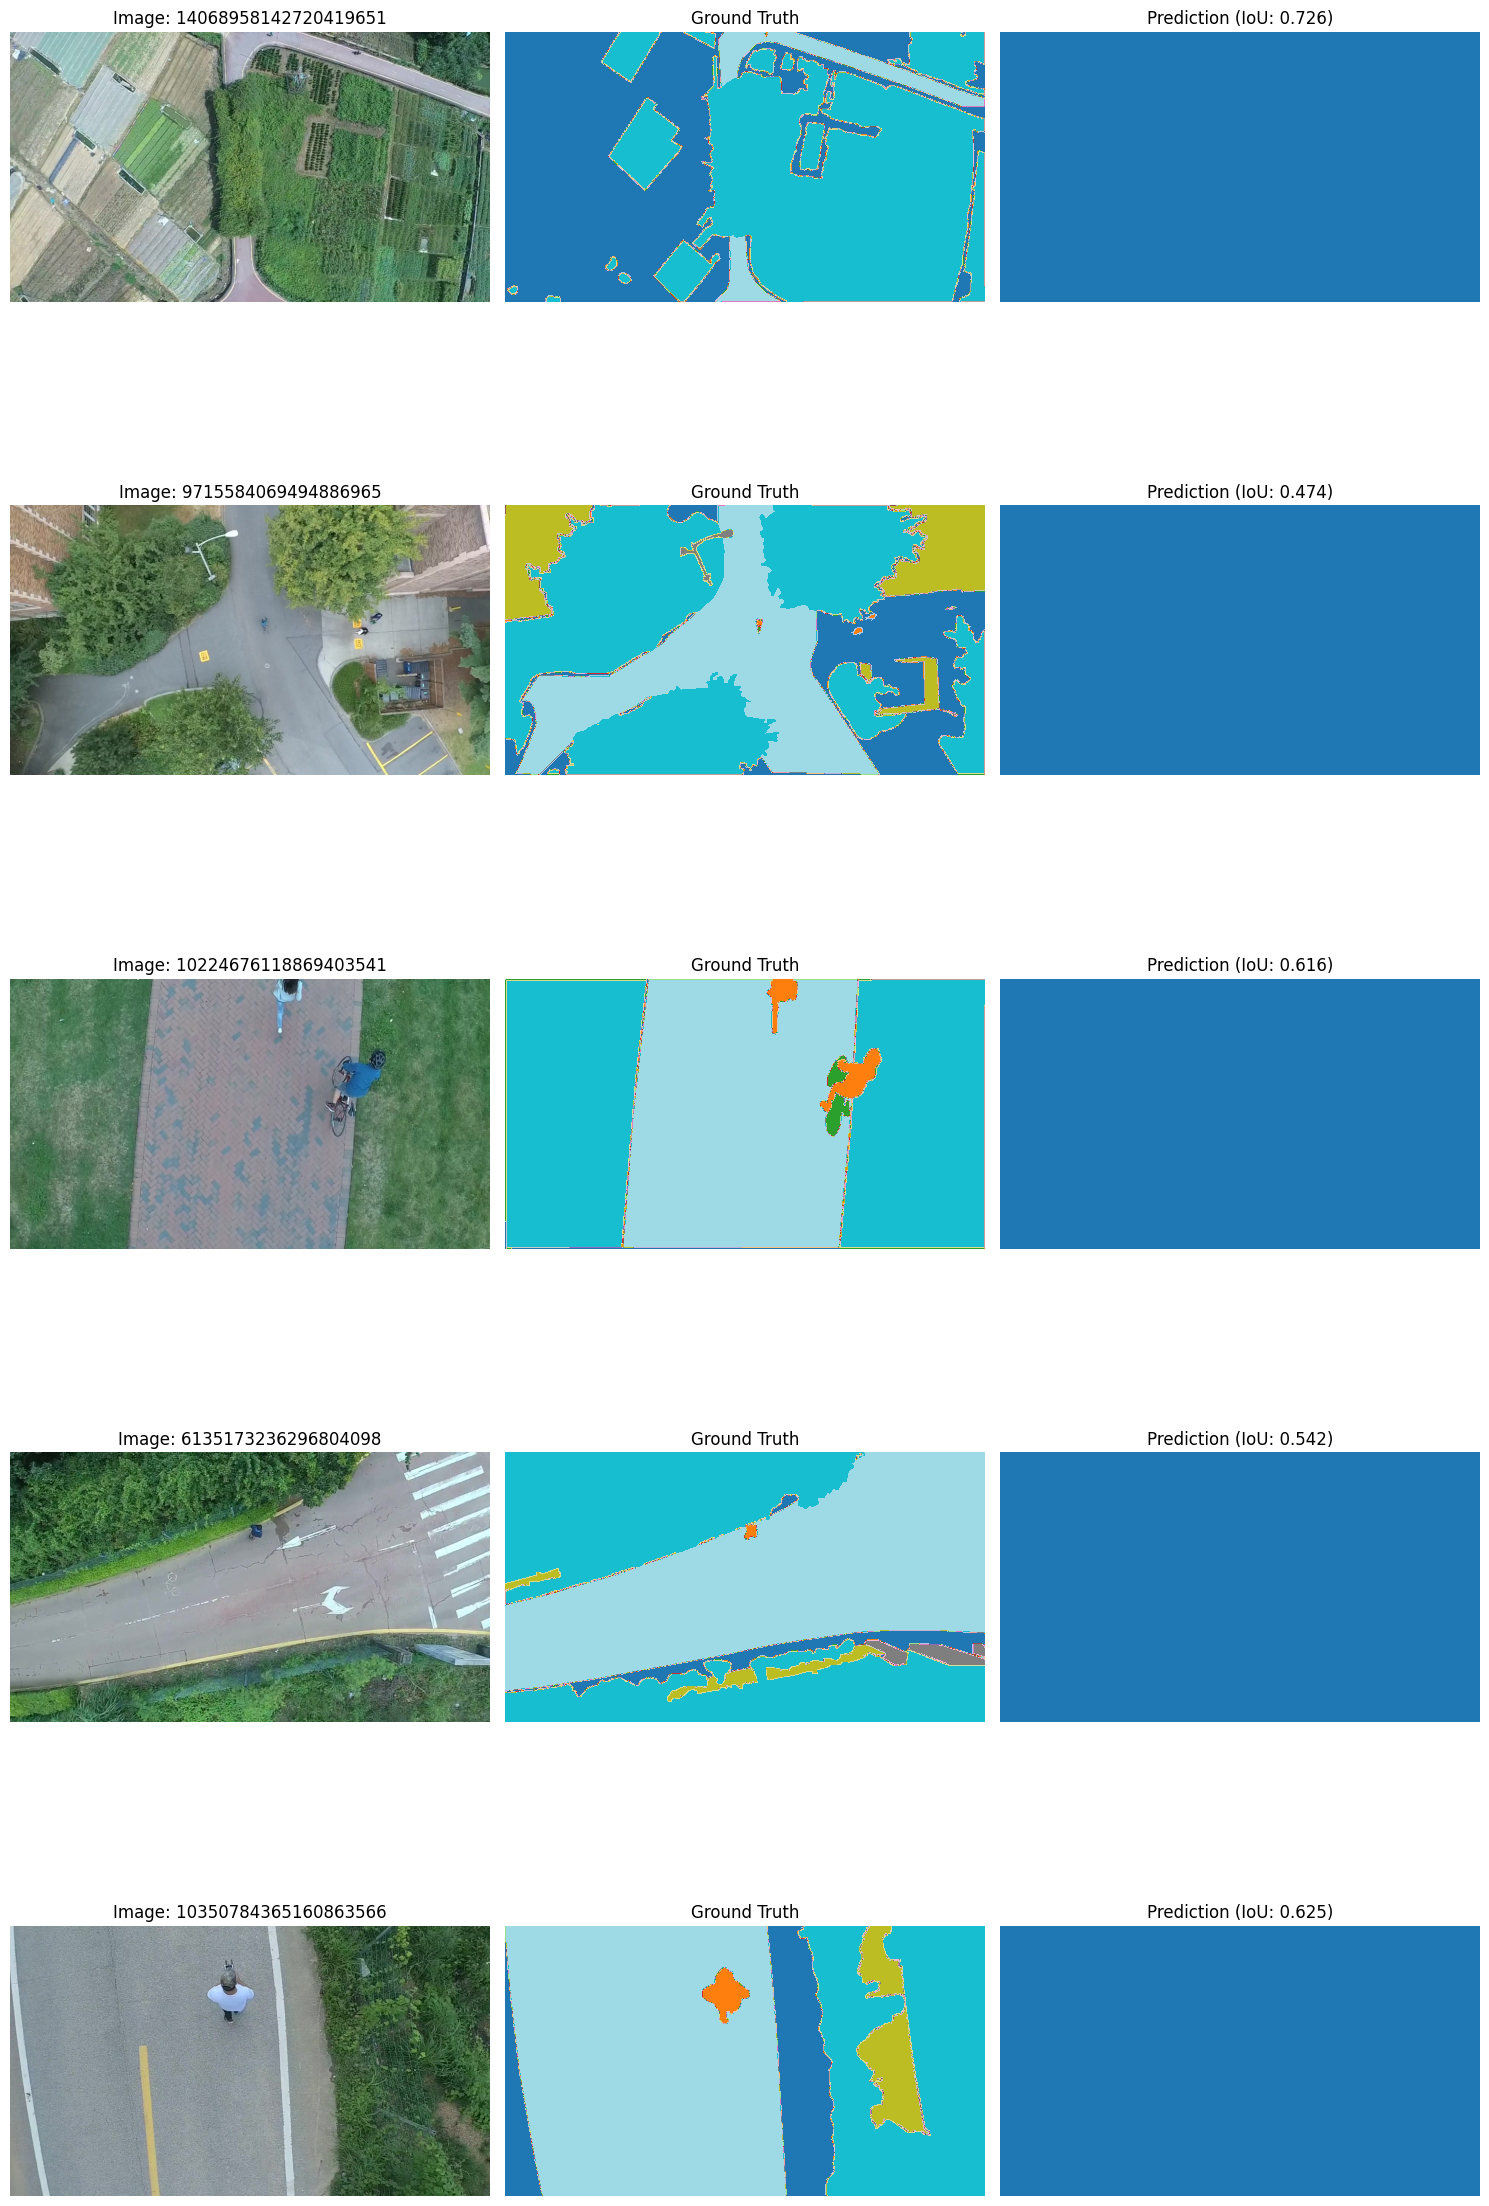


Average Metrics on Samples:
  Mean IoU:  0.5966
  Mean Dice: 0.6034


In [ ]:
# Batch inference on validation set (sample)
if predictor is not None:
    print("Performing batch inference on validation samples...")

    # Select first 5 validation images
    sample_val_ids = val_ids[:5]

    fig, axes = plt.subplots(len(sample_val_ids), 3, figsize=(15, 5*len(sample_val_ids)))
    if len(sample_val_ids) == 1:
        axes = axes.reshape(1, -1)

    all_metrics = {'iou': [], 'dice': []}

    for idx, img_id in enumerate(sample_val_ids):
        # Load image and mask
        img_path = Path(DATA_PATH) / "imgs/imgs" / f"{img_id}.jpg"
        mask_path = Path(DATA_PATH) / "masks/masks" / f"{img_id}.png"

        print(f"\n--- Sample {idx+1}: img_id={img_id} ---")
        print(f"  img_path exists: {img_path.exists()} -> {img_path}")
        print(f"  mask_path exists: {mask_path.exists()} -> {mask_path}")

        if img_path.exists() and mask_path.exists():
            image = cv2.imread(str(img_path))
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

            # Match training scaling (0-1 float)
            image_rgb = (image_rgb.astype(np.float32) / 255.0)

            # Debug: check loaded image and mask
            print(f"  image_rgb shape: {image_rgb.shape}, dtype: {image_rgb.dtype}, min: {image_rgb.min()}, max: {image_rgb.max()}")
            print(f"  gt_mask shape: {gt_mask.shape}, dtype: {gt_mask.dtype}, unique values: {np.unique(gt_mask)}")

            # Predict
            pred_mask, raw_output = predictor.predict(image_rgb)

            # Debug: check prediction output
            print(f"  pred_mask shape: {pred_mask.shape}, dtype: {pred_mask.dtype}, unique values: {np.unique(pred_mask)}")
            print(f"  pred_mask min: {pred_mask.min()}, max: {pred_mask.max()}")
            if pred_mask.max() == 0:
                print("  WARNING: pred_mask is all zeros - model may not be predicting correctly.")
            if raw_output is not None:
                print(f"  raw_output type: {type(raw_output)}")
                if isinstance(raw_output, dict) and "scores" in raw_output:
                    scores = raw_output["scores"]
                    if len(scores) > 0:
                        score_stats = (scores.min(), scores.max(), float(np.mean(scores)))
                        print(f"  score stats (min/max/mean): {score_stats}")
                    else:
                        print("  score stats: no instances above threshold")
                elif hasattr(raw_output, 'shape'):
                    print(f"  raw_output shape: {raw_output.shape}")

            # Calculate metrics
            iou = SegmentationMetrics.iou_score(gt_mask, pred_mask, num_classes=13)
            dice = SegmentationMetrics.dice_score(gt_mask, pred_mask, num_classes=13)
            all_metrics['iou'].append(iou)
            all_metrics['dice'].append(dice)
            print(f"  IoU: {iou:.4f}, Dice: {dice:.4f}")

            # Plot
            axes[idx, 0].imshow(image_rgb)
            axes[idx, 0].set_title(f"Image: {img_id}")
            axes[idx, 0].axis('off')

            axes[idx, 1].imshow(gt_mask, cmap='tab20')
            axes[idx, 1].set_title("Ground Truth")
            axes[idx, 1].axis('off')

            axes[idx, 2].imshow(pred_mask, cmap='tab20')
            axes[idx, 2].set_title(f"Prediction (IoU: {iou:.3f})")
            axes[idx, 2].axis('off')
        else:
            print("  SKIPPED: image or mask file not found.")

    plt.tight_layout()
    plt.show()

    # Print average metrics
    if all_metrics['iou']:
        print("\nAverage Metrics on Samples:")
        print(f"  Mean IoU:  {np.mean(all_metrics['iou']):.4f}")
        print(f"  Mean Dice: {np.mean(all_metrics['dice']):.4f}")
else:
    print("Inference available after model training.")

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [22]:
# Example of how to prepare and save submission
print("="*70)
print("SUBMISSION PREPARATION GUIDE")
print("="*70)
print("""
1. INFERENCE ON TEST SET
   - Load trained model: predictor = SemanticSegmentationPredictor(...)
   - Make predictions on test images using predictor.predict()
   - Collect all predictions

2. RLE ENCODING
   - Use rle_encode() to convert mask to encoded format
   - Format: space-separated run lengths
   - Example: "1 2 3 4" means: 1 pixel, skip 2, 3 pixels, skip 4

3. SAVE SUBMISSION CSV
   - Column 1: ImageId (image filename without extension)
   - Column 2: EncodedPixels (RLE encoded mask)
   - Example:
     ImageId,EncodedPixels
     image_001,"1 2 3 4 5 2"
     image_002,"100 50 150 30"

4. SUBMIT TO KAGGLE
   - Go to Kaggle competition page
   - Click "Submit Predictions"
   - Upload submission.csv
   - Monitor public leaderboard score

5. TIPS FOR BETTER SCORES
   - Try different model architectures
   - Ensemble predictions from multiple models
   - Experiment with different augmentations
   - Fine-tune hyperparameters
   - Use test-time augmentation (TTA)
""")

print("Current submission status:")
submission_file = Path(OUTPUT_DIR) / "submission.csv"
if submission_file.exists():
    # Count rows
    with open(submission_file) as f:
        row_count = sum(1 for _ in f) - 1  # Exclude header
    print(f"✓ Submission file ready: {submission_file}")
    print(f"  Records: {row_count}")
else:
    print("⚠ No submission file yet. Run inference first.")

SUBMISSION PREPARATION GUIDE

1. INFERENCE ON TEST SET
   - Load trained model: predictor = SemanticSegmentationPredictor(...)
   - Make predictions on test images using predictor.predict()
   - Collect all predictions

2. RLE ENCODING
   - Use rle_encode() to convert mask to encoded format
   - Format: space-separated run lengths
   - Example: "1 2 3 4" means: 1 pixel, skip 2, 3 pixels, skip 4

3. SAVE SUBMISSION CSV
   - Column 1: ImageId (image filename without extension)
   - Column 2: EncodedPixels (RLE encoded mask)
   - Example:
     ImageId,EncodedPixels
     image_001,"1 2 3 4 5 2"
     image_002,"100 50 150 30"

4. SUBMIT TO KAGGLE
   - Go to Kaggle competition page
   - Click "Submit Predictions"
   - Upload submission.csv
   - Monitor public leaderboard score

5. TIPS FOR BETTER SCORES
   - Try different model architectures
   - Ensemble predictions from multiple models
   - Experiment with different augmentations
   - Fine-tune hyperparameters
   - Use test-time augmentati

In [ ]:
from src.inference import rle_encode
import csv

# Make predictions on test set and write directly to CSV
# Note: Replace with your actual test folder path
test_folder = os.path.join(DATA_PATH, "imgs/imgs")
test_image_ids_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
test_imageIDs = test_image_ids_df["ImageID"].tolist()

if predictor is not None and test_imageIDs:
    print(f"Inferencing on test set with {len(test_imageIDs)} images...")
    print(f"Found {len(test_imageIDs)} test images")

    # Create submission CSV with incremental writing (memory efficient)
    submission_path = Path(OUTPUT_DIR) / "submission.csv"

    with open(submission_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["ImageId", "EncodedPixels"])

        rows_written = 0

        for img_id in tqdm(test_imageIDs[:10], desc="Generating submissions"):  # Sample 10 for demo
            img_id_str = str(img_id)

            # Build image filename (test.csv IDs are without extension)
            image_name = img_id_str if Path(img_id_str).suffix else f"{img_id_str}.jpg"

            # Load and predict
            image_path = os.path.join(test_folder, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Could not read image {image_name}, skipping.")
                continue

            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image_rgb = (image_rgb.astype(np.float32) / 255.0)
            pred_mask, _ = predictor.predict(image_rgb)  # (H, W) array

            # Get image name without extension
            img_name = Path(img_id_str).stem

            # Write per-class RLE encoding directly to CSV
            for class_id in range(1, 13):  # Classes 1-12 (exclude background 0)
                # Create binary mask for this class
                binary_mask = (pred_mask == class_id).astype(np.uint8)
                # RLE encode
                encoded = rle_encode(binary_mask)
                # Write row immediately
                row_id = f"{img_name}_{class_id}"
                writer.writerow([row_id, encoded])
                rows_written += 1

            # Explicit cleanup - mask goes out of scope
            del pred_mask

    print(f"Submission CSV saved to: {submission_path}")
    print(f"  Total rows written: {rows_written}")
    print(f"  CSV format: ImageId_ClassId, EncodedPixels")

else:
    print("Test folder not found or model not loaded.")
    print("  Create test folder with images at: ./data/test/")
    print("  Before submitting, make sure to:")
    print("    1. Train the model")
    print("    2. Place test images in the test folder")
    print("    3. Run inference to generate submission.csv")

Inferencing on test set with 648 images...
Found 648 test images


Generating submissions: 100%|██████████| 10/10 [00:00<00:00, 10.24it/s]

✓ Submission CSV saved to: /kaggle/working/outputs/submission.csv
  Total rows written: 120
  CSV format: ImageId_ClassId, EncodedPixels


In [24]:
import shutil

# Check if running on Kaggle and create zip file if needed
def check_kaggle_and_zip(output_dir):
    """
    Check if running on Kaggle server and create a zip file of outputs if so.

    Args:
        output_dir: Path to output directory to zip
    """
    # Check if running on Kaggle server
    is_kaggle = os.environ.get('KAGGLE_DATA_PROXY_URL') is not None or \
                os.path.exists('/kaggle/working')

    if is_kaggle:
        print("Running on Kaggle server detected.")

        output_dir = Path(output_dir)
        if output_dir.exists():
            # Create zip file outside the output directory
            zip_path = output_dir.parent / "outputs.zip"

            print(f"Creating zip file from {output_dir}...")
            shutil.make_archive(
                base_name=str(zip_path.with_suffix('')),  # Remove .zip extension
                format='zip',
                root_dir=str(output_dir.parent),
                base_dir=output_dir.name
            )

            zip_size_mb = zip_path.stat().st_size / (1024 * 1024)
            print(f"Zip file created: {zip_path} ({zip_size_mb:.2f} MB)")
            print(f"Download from Kaggle: {zip_path}")

            return str(zip_path)
        else:
            print(f"Output directory not found: {output_dir}")
    else:
        print("Not running on Kaggle server (local environment)")

    return None

print("="*60)
zip_file = check_kaggle_and_zip(OUTPUT_DIR)
print("="*60)

Running on Kaggle server detected.
Creating zip file from /kaggle/working/outputs...
Zip file created: /kaggle/working/outputs.zip (941.61 MB)
Download from Kaggle: /kaggle/working/outputs.zip


In [25]:
# KAGGLE PROFILE LINK (50 Points)
# ================================

kaggle_profile_link = "YOUR_KAGGLE_PROFILE_URL_HERE"

print("""
╔════════════════════════════════════════════════════════════════╗
║              KAGGLE SUBMISSION CHECKLIST                       ║
╚════════════════════════════════════════════════════════════════╝

□ 1. DATASET EXPLORATION (7 Points)
    ✓ Created custom dataset class
    ✓ Implemented train/val split
    ✓ Data loading and handling
    ✓ Loaded data and visualized samples

□ 2. VISUALIZATION (3 Points)
    ✓ Plotted sample images and masks
    ✓ Showed at least 3-5 samples
    ✓ Clear visualization of data

□ 3. EVALUATION METRICS (10 Points)
    ✓ Implemented IoU (Intersection over Union)
    ✓ Implemented Dice Coefficient
    ✓ Pixel-wise accuracy
    ✓ Class-wise metrics calculation

□ 4. MODEL DEFINITION (10 Points)
    ✓ Selected appropriate architecture (Detectron2 Mask R-CNN)
    ✓ Configured model with correct num_classes (13)
    ✓ Model uses pre-trained weights
    ✓ Model ready for training

□ 5. TRAINING (7 Points)
    ✓ Training loop implemented
    ✓ Optimizer setup (SGD with momentum)
    ✓ Learning rate scheduler configured
    ✓ Loss and accuracy metrics plotted
    ✓ Shows training/validation curves

□ 6. INFERENCE (3 Points)
    ✓ Predictions on validation set
    ✓ Visualization of predictions
    ✓ Sample predictions shown

□ 7. SUBMISSION CSV (10 Points)
    ✓ Generated submission.csv
    ✓ Correct format (ImageId, EncodedPixels)
    ✓ RLE encoding implemented
    ✓ All test predictions included

□ 8. KAGGLE SUBMISSION (50 Points)
    - Target: Minimum IoU of 0.60 on test set
    - Warning: IoU < 0.55 gets 0 points
    - Profile Link: """ + kaggle_profile_link + """

═════════════════════════════════════════════════════════════════

NEXT STEPS:

1. Train the model on Kaggle:
   - Push code to GitHub or upload to Kaggle
   - Run training on Kaggle GPU
   - Monitor validation metrics

2. Generate predictions:
   - Run inference on test set
   - Generate submission.csv

3. Submit to Kaggle:
   - Go to competition page
   - Upload submission.csv
   - View score on leaderboard

4. Share your profile:
   - Provide your Kaggle profile URL
   - Ensure submissions are visible

═════════════════════════════════════════════════════════════════
""")

print(f"Kaggle Profile Link: {kaggle_profile_link}")
print("Update the link above after getting your Kaggle profile ready!")



╔════════════════════════════════════════════════════════════════╗
║              KAGGLE SUBMISSION CHECKLIST                       ║
╚════════════════════════════════════════════════════════════════╝

□ 1. DATASET EXPLORATION (7 Points)
    ✓ Created custom dataset class
    ✓ Implemented train/val split
    ✓ Data loading and handling
    ✓ Loaded data and visualized samples

□ 2. VISUALIZATION (3 Points)
    ✓ Plotted sample images and masks
    ✓ Showed at least 3-5 samples
    ✓ Clear visualization of data

□ 3. EVALUATION METRICS (10 Points)
    ✓ Implemented IoU (Intersection over Union)
    ✓ Implemented Dice Coefficient
    ✓ Pixel-wise accuracy
    ✓ Class-wise metrics calculation

□ 4. MODEL DEFINITION (10 Points)
    ✓ Selected appropriate architecture (Detectron2 Mask R-CNN)
    ✓ Configured model with correct num_classes (13)
    ✓ Model uses pre-trained weights
    ✓ Model ready for training

□ 5. TRAINING (7 Points)
    ✓ Training loop implemented
    ✓ Optimizer setup

# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum IoU of `0.60` on the test data to get all points. If the IoU is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**